# Example Datasets

cartoframes' example datasets functionality allows users to learn cartoframes features 1) without needing to authenticate against their account, or 2) using pre-packaged data to follow along in notebooks

In [1]:
from cartoframes.examples import example_context
from cartoframes import Layer, QueryLayer

## List available tables

In [2]:
[table.name for table in example_context.tables()]

['mcdonalds_nyc', 'nyc_census_tracts', 'brooklyn_poverty', 'taxi_50k', 'nat']

## Brooklyn Poverty Data

In [3]:
from cartoframes.examples import read_brooklyn_poverty
df = read_brooklyn_poverty()
df.head()

commuters_16_over_2011_2015         geoid  \
cartodb_id                                              
2052                                NaN  360479901000   
1606                                0.0  360470702031   
1572                                NaN  360470666000   
17                               5058.0  360470534004   
53                               4230.0  360470593001   

            pop_determined_poverty_status_2011_2015  poverty_count  \
cartodb_id                                                           
2052                                            NaN            NaN   
1606                                            0.0            NaN   
1572                                            NaN            NaN   
17                                          23191.0          377.0   
53                                          10804.0          117.0   

            poverty_per_pop  \
cartodb_id                    
2052                    NaN   
1606                    NaN   
1572                    NaN   
17                 0.406394   
53                 0.098598   

                                                     the_geom  \
cartodb_id                                                      
2052                                                     None   
1606        0106000020E61000000800000001030000000100000013...   
1572                                                     None   
17          0106000020E6100000010000000103000000010000000B...   
53          0106000020E6100000010000000103000000010000000E...   

            total_pop_2011_2015  total_population  \
cartodb_id                                          
2052                        NaN                 0   
1606                        0.0                 0   
1572                        NaN                 0   
17                      21451.0               928   
53                       8116.0              1185   

            walked_to_work_2011_2015_per_pop  
cartodb_id                                    
2052                                     NaN  
1606                                     NaN  
1572                                     NaN  
17                                  0.018761  
53                                  0.031915

### Sample map

In [4]:
# Interactive map
example_context.map(Layer('brooklyn_poverty', color='poverty_per_pop'))

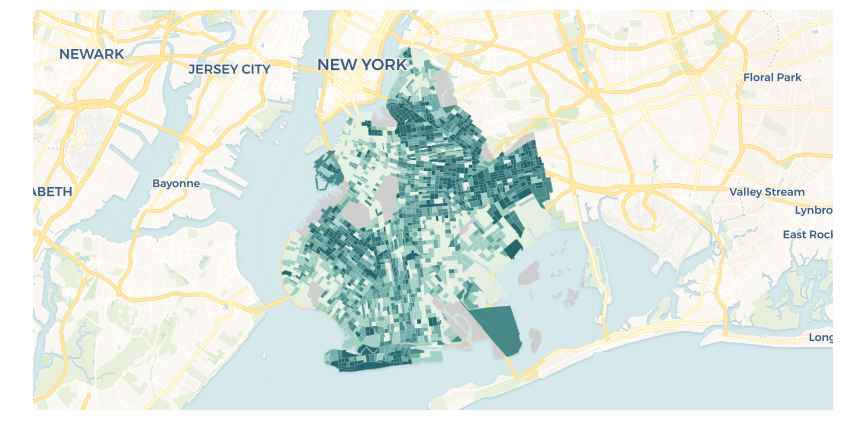

In [5]:
# Interactive map
example_context.map(
    Layer('brooklyn_poverty', color='poverty_per_pop'),
    interactive=False)

## Taxi Data

In [6]:
from cartoframes.examples import read_taxi
df = read_taxi()
df.head()

dropoff_latitude  dropoff_longitude  extra  fare_amount  \
cartodb_id                                                            
1                  40.706779         -74.012383    0.0          8.5   
2                  40.762779         -73.973824    0.0         13.5   
3                  40.740833         -73.998955    0.0         14.5   
4                  40.792370         -73.966362    0.5         15.0   
5                  40.784939         -73.956963    0.0         19.5   

            improvement_surcharge  mta_tax  passenger_count  payment_type  \
cartodb_id                                                                  
1                             0.3      0.5                2             1   
2                             0.3      0.5                1             1   
3                             0.3      0.5                1             2   
4                             0.3      0.5                1             2   
5                             0.3      0.5                2             1   

            pickup_latitude  pickup_longitude  ratecodeid  store_and_fwd_flag  \
cartodb_id                                                                      
1                 40.730461        -74.006706           1               False   
2                 40.744125        -73.924957           1               False   
3                 40.748501        -73.973488           1               False   
4                 40.743267        -73.999786           1               False   
5                 40.803360        -73.963631           1               False   

           the_geom  tip_amount  tolls_amount  total_amount  \
cartodb_id                                                    
1              None        1.00           0.0         10.30   
2              None        2.00           0.0         16.30   
3              None        0.00           0.0         15.30   
4              None        0.00           0.0         16.30   
5              None        4.06           0.0         24.36   

           tpep_dropoff_datetime tpep_pickup_datetime  trip_distance  vendorid  
cartodb_id                                                                      
1            2016-05-01 15:00:36  2016-05-01 14:52:11           2.08         2  
2            2016-05-01 08:49:02  2016-05-01 08:34:08           3.00         1  
3            2016-05-04 10:07:09  2016-05-04 09:44:40           2.10         1  
4            2016-05-01 21:05:24  2016-05-01 20:50:11           4.41         2  
5            2016-05-02 07:53:53  2016-05-02 07:26:56           4.01         2

To visualize this data, we need to add a column called `the_geom` to visualize. Using `example_context` we can call the `query` method to get the data or `QueryLayer` to visualize on a map.

If we try to map it, we will get an error because this dataset doesn't have explicit geometries.

In [7]:
example_context.map(Layer('taxi_50k'))

ValueError: No geometry for layer. Check all layer tables and queries to ensure there are geometries.

### Creating a geometry

There are many ways to create geometries from the lng/lat pairs in the taxi dataset. Here we will do a "crow fly" distance (converted from meters to miles) between pickups and drop-offs.

In [8]:
q = '''
SELECT
  *,
  ST_Transform(the_geom, 3857) as the_geom_webmercator,
  ST_Length(the_geom::geography) / 1609 as crow_dist
FROM (
    SELECT
      ST_MakeLine(CDB_LatLng(pickup_latitude, pickup_longitude), CDB_LatLng(dropoff_latitude, dropoff_longitude)) as the_geom,
      cartodb_id,
      fare_amount,
      trip_distance
    FROM taxi_50k
    WHERE pickup_latitude <> 0 and dropoff_latitude <> 0
) as _w
'''
example_context.map(
    QueryLayer(q, color='fare_amount', opacity=0.05),
    zoom=12, lng=-73.9503, lat=40.7504
)

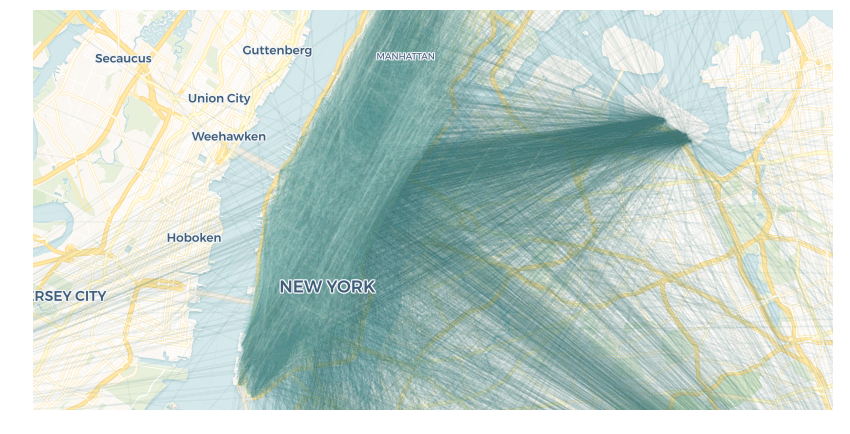

In [9]:
# static view
example_context.map(
    QueryLayer(q, color='fare_amount', opacity=0.05),
    zoom=12, lng=-73.9503, lat=40.7504,
    interactive=False
)

We can use that same query to get the line geometries, and compare the crow fly distance with the reported distance.

In [10]:
taxi_lines = example_context.query(q)
taxi_lines.head()

crow_dist  fare_amount  \
cartodb_id                           
1            1.661395          8.5   
2            2.869732         13.5   
3            1.437734         14.5   
4            3.815911         15.0   
5            1.318624         19.5   

                                                     the_geom  trip_distance  
cartodb_id                                                                    
1           0102000020E610000002000000020000E06D8052C00400...           2.08  
2           0102000020E610000002000000FEFFFF7F327B52C0FBFF...           3.00  
3           0102000020E610000002000000000000A04D7E52C0FFFF...           2.10  
4           0102000020E610000002000000FEFFFF7FFC7F52C00400...           4.41  
5           0102000020E610000002000000FEFFFF1FAC7D52C00500...           4.01

## Nat dataset

In [11]:
from cartoframes import styling
example_context.map(Layer('nat', color={'column': 'hr90', 'scheme': styling.sunset(7)}))